In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

iris = load_iris()
X = iris.data[:, 2:] # Petal length and width
y = iris['target']

## Classification

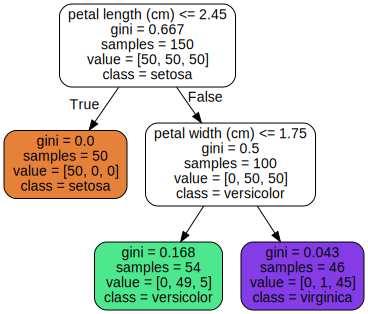

In [33]:
import graphviz

tree_clf = DecisionTreeClassifier(max_depth=2).fit(X, y)

export_graphviz(
    tree_clf,
    out_file='./iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

graphviz.Source.from_file('./iris_tree.dot')

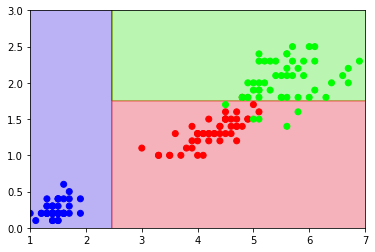

In [34]:
def plot_predict_proba(clf, axes, *args, **kwargs):
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)

    x0, x1 = np.meshgrid(x0s, x1s)
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_pred_proba = clf.predict(X_new).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred_proba, cmap=plt.cm.brg, alpha=0.3)

plot_predict_proba(tree_clf, [1, 7, 0, 3])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.brg)
plt.show()

## Regression

In [48]:
X = np.random.rand(100)
y = 2 * X**2 - 2 * X + 0.5 + np.random.rand(100) / 5
X = X.reshape(-1, 1)

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor().fit(X, y)
tree_reg_regular = DecisionTreeRegressor(max_depth=4).fit(X, y)

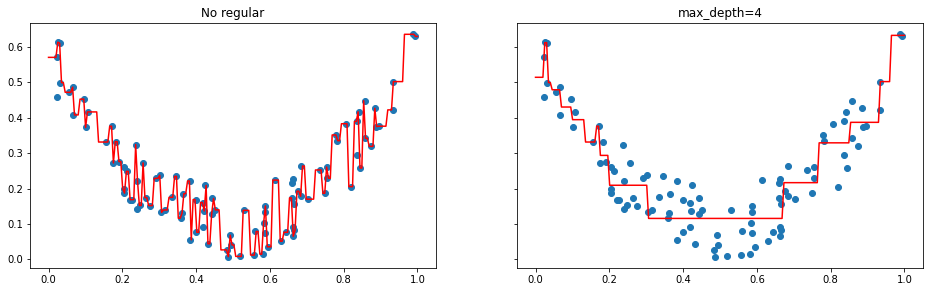

In [56]:
def plot_regressor(clf, x_min, x_max, *args, **kwargs):
    X = np.linspace(x_min, x_max, 200).reshape(-1, 1)
    y = clf.predict(X)
    plt.plot(X, y, *args, **kwargs)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16, 4.5))

plt.sca(axs[0])
plt.title('No regular')
plt.scatter(X, y)
plot_regressor(tree_reg, 0, 1, c='red')

plt.sca(axs[1])
plt.title('max_depth=4')
plot_regressor(tree_reg_regular, 0, 1, c='red')
plt.scatter(X, y)

plt.show()